data from [single-cell RNA expression atlas of normal, preneoplastic and tumorigenic states in the human breast](https://doi.org/10.15252/embj.2020107333)

In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets


import torch
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import resources

import anndata
import scanpy as sc

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}breast_cancer_2021/processed_data/TNBC.h5ad")
adata_her2 = anndata.read_h5ad(
    f"{DATA_FOLDER}breast_cancer_2021/processed_data/HER2.h5ad"
)
adata_ERTotal = anndata.read_h5ad(
    f"{DATA_FOLDER}breast_cancer_2021/processed_data/ERTotal.h5ad"
)
# adata = anndata.read_h5ad("../data/cellcycle_maxine/different_cell_types/phase_VASA.h5ad")
adata

AnnData object with n_obs × n_vars = 54820 × 24867
    obs: 'orig_file', 'group', 'n_counts', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.1', 'seurat_clusters'

In [4]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AADAC', 'AADACL2-AS1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=24867)

In [5]:
adata.obs["group"].unique()

['TN_B1_0131', 'TN_0114_T2', 'TN_0106', 'TN_B1_4031', 'TN_B1_0177', 'TN_0135', 'TN_0126', 'TN_B1_0554']
Categories (8, object): ['TN_0106', 'TN_0114_T2', 'TN_0126', 'TN_0135', 'TN_B1_0131', 'TN_B1_0177', 'TN_B1_0554', 'TN_B1_4031']

In [6]:
adata.obs["cancer_type"] = "TNBC"
adata_her2.obs["cancer_type"] = "HER2+"
adata_ERTotal.obs["cancer_type"] = "ER"

In [7]:
not_cycling = anndata.concat(
    [
        adata[adata.obs["seurat_clusters"].apply(lambda x: x in [0])].copy(),
        adata_her2[adata_her2.obs["seurat_clusters"].apply(lambda x: x in [0])].copy(),
        adata_ERTotal[
            adata_ERTotal.obs["seurat_clusters"].apply(lambda x: x in [0])
        ].copy(),
    ]
)

In [8]:
not_cycling.obs

orig_file       group  n_counts  \
TN_B1_0131_AAACCTGCACATGTGT-1  GSM4909286_TN-B1-MH0131  TN_B1_0131   21404.0   
TN_B1_0131_AAACCTGCAGCTTCGG-1  GSM4909286_TN-B1-MH0131  TN_B1_0131    4175.0   
TN_B1_0131_AAACCTGGTCATGCAT-1  GSM4909286_TN-B1-MH0131  TN_B1_0131    7444.0   
TN_B1_0131_AAACCTGGTGACCAAG-1  GSM4909286_TN-B1-MH0131  TN_B1_0131   33822.0   
TN_B1_0131_AAACCTGGTTAAGAAC-1  GSM4909286_TN-B1-MH0131  TN_B1_0131   41062.0   
...                                                ...         ...       ...   
ER_0167_T_TTTGTTGCAAAGACTA-1    GSM4909315_ER-MH0167-T   ER_0167_T    5903.0   
ER_0167_T_TTTGTTGGTGACTCGC-1    GSM4909315_ER-MH0167-T   ER_0167_T    4389.0   
ER_0167_T_TTTGTTGGTTCTATCT-1    GSM4909315_ER-MH0167-T   ER_0167_T    4326.0   
ER_0167_T_TTTGTTGTCGCAATTG-1    GSM4909315_ER-MH0167-T   ER_0167_T   13518.0   
ER_0167_T_TTTGTTGTCGCCGAGT-1    GSM4909315_ER-MH0167-T   ER_0167_T   33771.0   

                              orig.ident  nCount_RNA  nFeature_RNA  \
TN_B1_0131_AAACCTGCACATGTGT-1         TN     18718.0        3255.0   
TN_B1_0131_AAACCTGCAGCTTCGG-1         TN      3495.0        1320.0   
TN_B1_0131_AAACCTGGTCATGCAT-1         TN      6704.0        1732.0   
TN_B1_0131_AAACCTGGTGACCAAG-1         TN     30297.0        4420.0   
TN_B1_0131_AAACCTGGTTAAGAAC-1         TN     34238.0        4623.0   
...                                  ...         ...           ...   
ER_0167_T_TTTGTTGCAAAGACTA-1          ER      5857.0        1739.0   
ER_0167_T_TTTGTTGGTGACTCGC-1          ER      4019.0        1734.0   
ER_0167_T_TTTGTTGGTTCTATCT-1          ER      4187.0        1979.0   
ER_0167_T_TTTGTTGTCGCAATTG-1          ER     13126.0        2815.0   
ER_0167_T_TTTGTTGTCGCCGAGT-1          ER     30268.0        4706.0   

                               seurat_clusters cancer_type  
TN_B1_0131_AAACCTGCACATGTGT-1              0.0        TNBC  
TN_B1_0131_AAACCTGCAGCTTCGG-1              0.0        TNBC  
TN_B1_0131_AAACCTGGTCATGCAT-1              0.0        TNBC  
TN_B1_0131_AAACCTGGTGACCAAG-1              0.0        TNBC  
TN_B1_0131_AAACCTGGTTAAGAAC-1              0.0        TNBC  
...                                        ...         ...  
ER_0167_T_TTTGTTGCAAAGACTA-1               0.0          ER  
ER_0167_T_TTTGTTGGTGACTCGC-1               0.0          ER  
ER_0167_T_TTTGTTGGTTCTATCT-1               0.0          ER  
ER_0167_T_TTTGTTGTCGCAATTG-1               0.0          ER  
ER_0167_T_TTTGTTGTCGCCGAGT-1               0.0          ER  

[69879 rows x 8 columns]

In [9]:
adata = adata[
    adata.obs["seurat_clusters"].apply(lambda x: x in [2])
].copy()  # select epi cells in cell cycle, based on fig 6 and EV2, https://doi.org/10.15252/embj.2020107333
adata_her2 = adata_her2[
    adata_her2.obs["seurat_clusters"].apply(lambda x: x in [3])
].copy()
adata_ERTotal = adata_ERTotal[
    adata_ERTotal.obs["seurat_clusters"].apply(lambda x: x in [4])
].copy()

In [10]:
adata = anndata.concat([adata, adata_her2, adata_ERTotal], join="outer")

In [11]:
adata.obs["cycling"] = True
not_cycling.obs["cycling"] = False

In [12]:
adata = anndata.concat([adata, not_cycling])

In [13]:
adata.obs["group"].unique()

['TN_B1_0131', 'TN_0114_T2', 'TN_0106', 'TN_B1_4031', 'TN_B1_0177', ..., 'ER_0042', 'ER_0319', 'ER_0360', 'ER_0151', 'ER_0167_T']
Length: 27
Categories (27, object): ['ER_0001', 'ER_0025', 'ER_0032', 'ER_0040_T', ..., 'TN_B1_0131', 'TN_B1_0177', 'TN_B1_0554', 'TN_B1_4031']

In [14]:
adata_all_genes = adata.copy()
library_size = adata_all_genes.X.sum(axis=1).A1
adata.layers["raw"] = adata.X.copy()
utils.add_histones_fraction(adata=adata, layer="raw")

In [15]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
SMALL_CYCLING_GENE_SET = [g.upper() for g in SMALL_CYCLING_GENE_SET]
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 85542 × 98
    obs: 'orig_file', 'group', 'n_counts', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'cancer_type', 'cycling', 'histones_fraction'
    layers: 'raw'

In [17]:
# mean center the adata
adata.X = adata.X - adata.X.mean(axis=1)

/tmp/ipykernel_372464/1782500935.py:2: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:636: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_372464/1782500935.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  sel

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


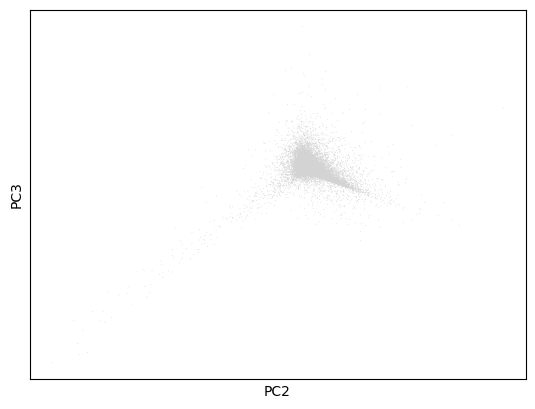

In [18]:
# pca on the data
sc.pp.pca(adata)
# plot the pca
sc.pl.pca(adata, components="2,3")

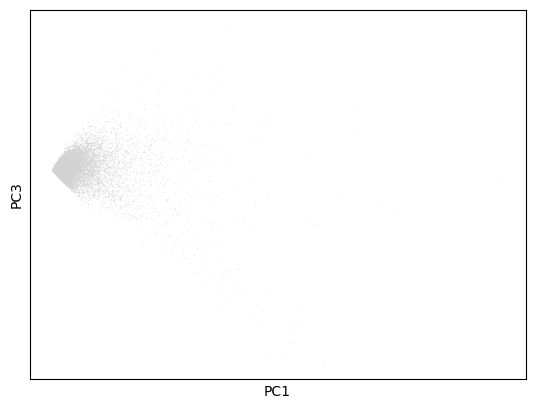

In [19]:
sc.pl.pca(adata, components="1,3")

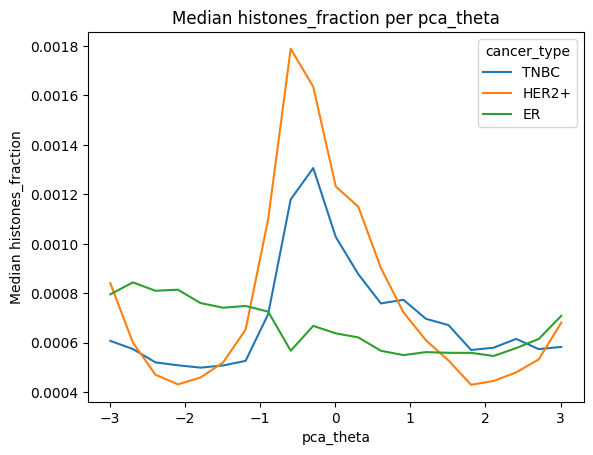

In [20]:
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 3], adata.obsm["X_pca"][:, 2]
)
plotting.plot_smoothed_size_evolution(
    adata,
    "pca_theta",
    counts_sum_field="histones_fraction",
    hue="cancer_type",
)

In [21]:
# add PCA theta to adata.obs
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 1], adata.obsm["X_pca"][:, 0]
)
adata_all_genes.obs["pca_theta"] = adata.obs["pca_theta"].copy()
adata = adata_all_genes.copy()

<Axes: ylabel='Frequency'>

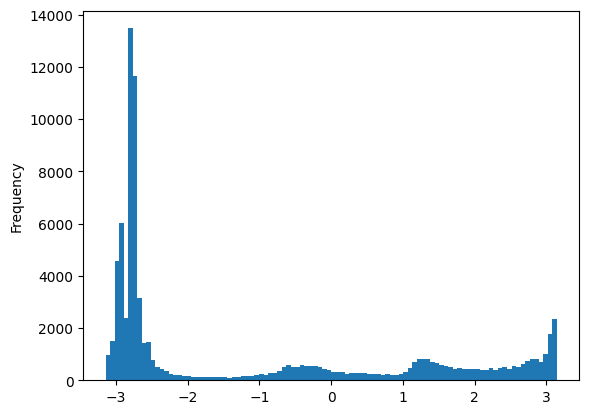

In [22]:
adata.obs["pca_theta"].plot.hist(bins=100)

In [23]:
adata = adata_all_genes.copy()

In [24]:
adata.layers["total"] = adata.X

In [25]:
g = utils.get_variable_genes(adata, 2000, layer="total")
len(g)

2000

In [26]:
adata.obs["group"].nunique()

27

In [27]:
SMALL_CYCLING_GENE_SET = np.array(
    list(set(SMALL_CYCLING_GENE_SET) & set(adata.var_names))
)

In [28]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
    n_latent=10,
    n_harm=3,
    use_mu_z_encoder=True,
    z_range=20,
    rhythmic_z_scale=2,
    lambda_range=1,
)  # , categorical_covariate_dims=[27])
model.load_anndata(
    adata, layer_to_use="total"
)  # , batch_name="cancer_type")#,categorical_covariates=["group"])

In [ ]:
f_coeffs_path = (
    resources.files("CoPhaser") / "ressources" / "fourier_coefficients_RPE.csv"
)
f_coeffs = pd.read_csv(f_coeffs_path, index_col=0)
f_coeffs.drop("A_0", axis=1, inplace=True)
f_coeffs = f_coeffs.loc[model.rhythmic_gene_names].copy()
old_weights = model.rhythmic_decoder.fourier_coefficients.weight.detach().clone()
old_weights[model.rhythmic_gene_indices, :] = torch.tensor(f_coeffs.values).float()
old_weights = torch.nn.Parameter(old_weights)
model.rhythmic_decoder.fourier_coefficients.weight = old_weights
model.rhythmic_decoder.freeze_weights_genes(model.rhythmic_gene_indices)

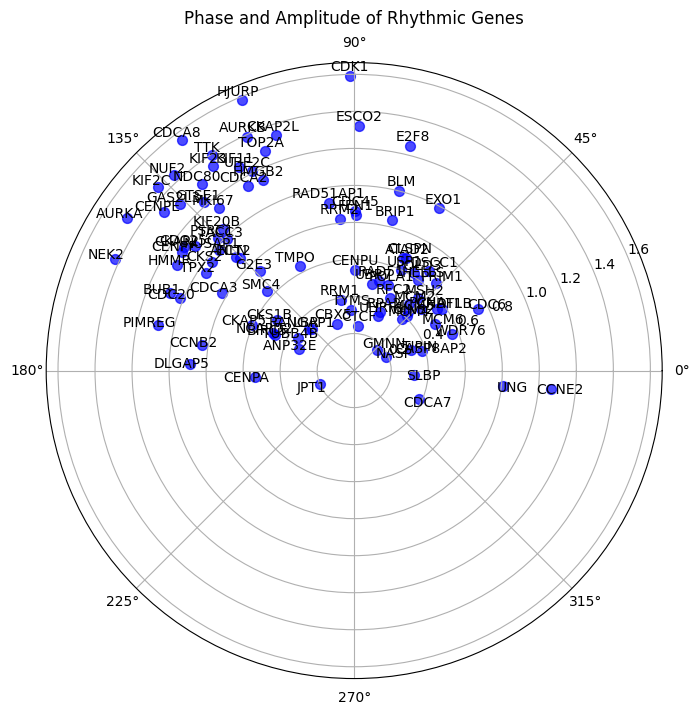

In [30]:
model.plot_fourier_coefficients()

Epoch 1/200, elbo_loss: 4069.3214, kl_div_f: 4.6779, kl_div_z: 33.9691, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.1793, entropy_loss: -317.9307, radial_variance: 4.3440, radius: 5.8392, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 3761.5740
Epoch 2/200, elbo_loss: 3379.5548, kl_div_f: 4.6213, kl_div_z: 39.5843, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2987, entropy_loss: -329.8676, radial_variance: 2.4623, radius: 4.2111, L1_mu_z: 0.0000, MI_loss: 0.0044, total_loss: 3056.8016
Epoch 3/200, elbo_loss: 3161.2368, kl_div_f: 4.5642, kl_div_z: 39.0684, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3702, entropy_loss: -337.0245, radial_variance: 1.2926, radius: 5.2877, L1_mu_z: 0.0000, MI_loss: 0.0189, total_loss: 2832.6863
Epoch 4/200, elbo_loss: 3043.7763, kl_div_f: 4.5032, kl_div_z: 39.5092, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3866, en

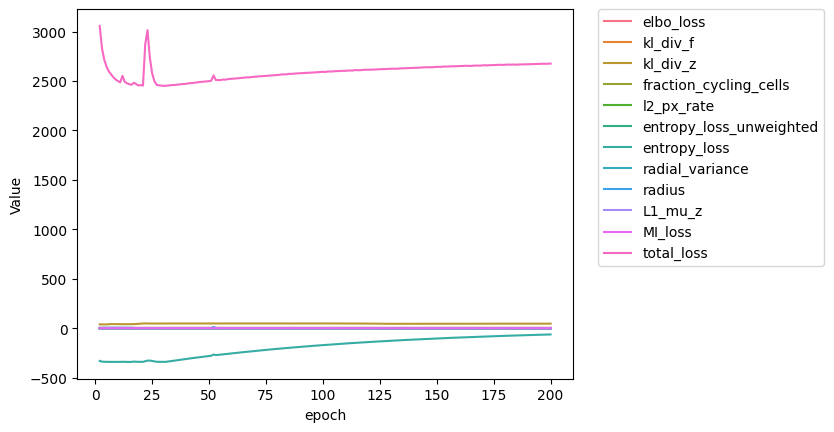

In [31]:
trainer = Trainer(
    model,
    Loss.compute_loss,
    calculate_entropy_per_batch=False,
    L2_Z_decoder_loss_weight=0,
    entropy_weight_factor=100,
    closed_circle_weight=10,
    MI_weight=100,
    cycling_status_prior=0.1,
    beta_kl_cycling_status=20,
    unfreeze_epoch_layer=[(20, "rhythmic_decoder")],
    rhythmic_likelihood_weight=20,
    non_rhythmic_likelihood_weight=5,
)  # , entropy_weight_factor=5)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=4096,
)

<Axes: ylabel='Count'>

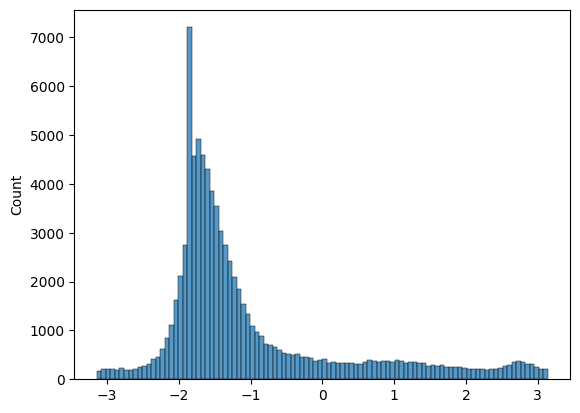

In [32]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(thetas, bins=100)

In [33]:
i_cycling = space_outputs["cycling_logits"].detach().numpy() > 25
i_cycling = np.where(i_cycling)[0]

In [34]:
i_g1 = (
    adata.obs[space_outputs["cycling_logits"].detach().numpy() < 25]
    .sample(frac=0.3)
    .index
)

<Axes: ylabel='Count'>

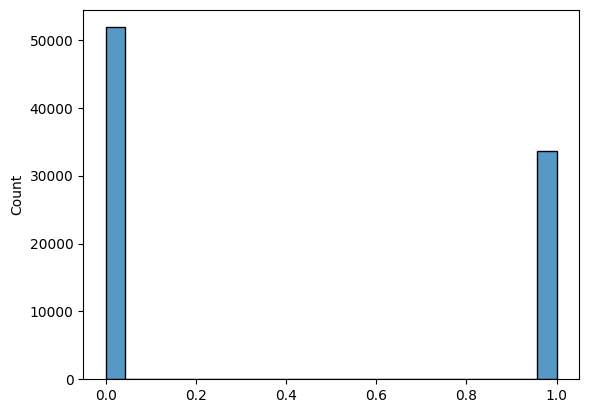

In [35]:
sns.histplot(x=space_outputs["b_z"].detach().numpy() > 0.5)

In [36]:
cycling_cells = space_outputs["b_z"] > 0.5

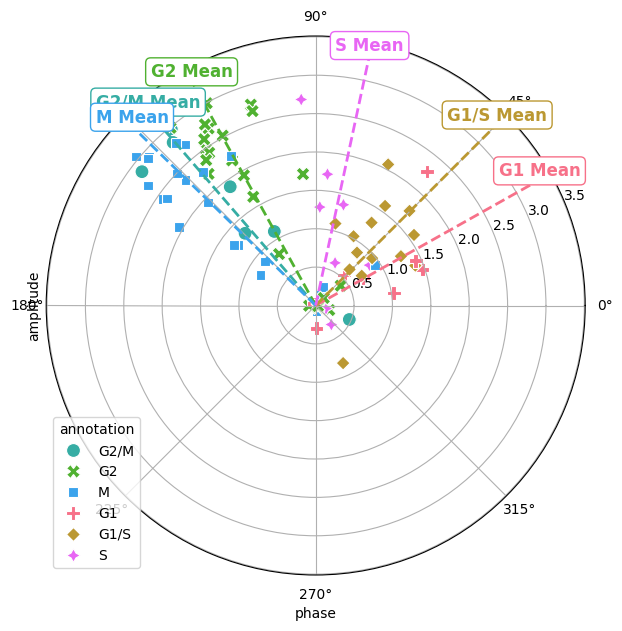

In [37]:
thetas = model.infer_pseudotimes(adata, "total")

In [38]:
g1_g0_cells = ((thetas > -1.75) & (thetas < -1.25)).numpy()

In [39]:
def match_phase_distributions(phases1, phases2, n_bins=20):
    """
    Find indices from phases1 that match the distribution of phases2.

    Parameters:
    -----------
    phases1 : array-like
        First array of phases (between -pi and pi)
    phases2 : array-like
        Second array of phases (between -pi and pi) - target distribution
    n_bins : int
        Number of bins to use for phase distribution

    Returns:
    --------
    indices : ndarray
        Indices from phases1 that match phases2 distribution
    """
    phases1 = np.asarray(phases1)
    phases2 = np.asarray(phases2)

    # Create bins from -pi to pi
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)

    # Bin both phase arrays
    bin_indices1 = np.digitize(phases1, bins) - 1
    bin_indices2 = np.digitize(phases2, bins) - 1

    # Clip to valid range [0, n_bins-1]
    bin_indices1 = np.clip(bin_indices1, 0, n_bins - 1)
    bin_indices2 = np.clip(bin_indices2, 0, n_bins - 1)

    # Count how many samples we need from each bin (target distribution)
    target_counts = np.bincount(bin_indices2, minlength=n_bins)

    # Find which elements of phases1 belong to each bin
    bin_members = [np.where(bin_indices1 == i)[0] for i in range(n_bins)]

    # Calculate the maximum scaling factor where 95% of bins have enough samples
    # Find bins that have non-zero target counts
    active_bins = target_counts > 0
    n_active_bins = np.sum(active_bins)

    if n_active_bins == 0:
        return np.array([], dtype=int)

    # Calculate availability ratio for each active bin
    availability_ratios = np.zeros(n_bins)
    for bin_idx in range(n_bins):
        if target_counts[bin_idx] > 0:
            available_count = len(bin_members[bin_idx])
            availability_ratios[bin_idx] = available_count / target_counts[bin_idx]

    # Sort ratios for active bins and find the 5th percentile
    # (95% of bins will have at least this ratio)
    active_ratios = availability_ratios[active_bins]
    active_ratios_sorted = np.sort(active_ratios)
    percentile_5_idx = max(0, int(np.ceil(0.05 * len(active_ratios_sorted))) - 1)
    scaling_factor = active_ratios_sorted[percentile_5_idx]

    # Scale down all target counts by this factor
    scaled_counts = np.floor(target_counts * scaling_factor).astype(int)

    # Sample from each bin according to scaled counts
    selected_indices = []

    for bin_idx in range(n_bins):
        available = bin_members[bin_idx]
        needed = scaled_counts[bin_idx]

        if needed == 0 or len(available) == 0:
            continue

        # Randomly sample without replacement (no reusing indices)
        needed = min(needed, len(available))
        chosen = np.random.choice(available, size=needed, replace=False)
        selected_indices.extend(chosen)

    return np.array(selected_indices, dtype=int)

In [40]:
g1_g0_cells = match_phase_distributions(
    thetas[cycling_cells.detach().numpy()],
    thetas[~cycling_cells.detach().numpy()],
    n_bins=100,
)
# get indices in the original adata
g1_g0_indices = adata[cycling_cells.detach().numpy()].obs.index[g1_g0_cells]
# transform it into a mask
g1_g0_indices = adata.obs.index.isin(g1_g0_indices)

In [41]:
cycling_cells[g1_g0_indices]

tensor([True, True, True,  ..., True, True, True])

<Axes: ylabel='Count'>

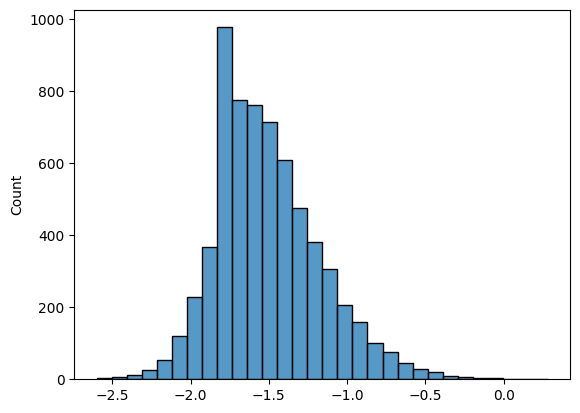

In [43]:
sns.histplot(thetas[g1_g0_indices], bins=30)

<Axes: ylabel='Count'>

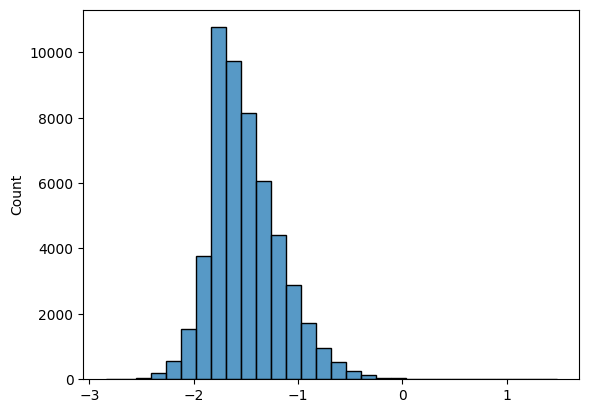

In [44]:
sns.histplot(thetas[~cycling_cells], bins=30)

In [45]:
from CoPhaser.model import interpretability

g1_g0_cells = ((thetas > -1.75) & (thetas < -1.25)).numpy()
res = {}
for subtype in adata.obs["orig.ident"].unique():
    print(subtype)
    i = adata.obs["orig.ident"] == subtype
    i = i & g1_g0_cells
    gene_importance = interpretability.compute_feature_importance(
        model, space_field="b_z", batch_size=2048, device="cuda", mask_cells=i
    )
    gene_importance = pd.Series(
        gene_importance[0], index=model.context_genes
    ).sort_values(ascending=False, key=abs)
    res[subtype] = gene_importance

TN


/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/model/interpretability.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_variable = x_variable[mask_cells]
/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/model/interpretability.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  library_size = library_size[mask_cells]


HER2
ER


In [46]:
# find genes in top 20 that are not in SMALL_CYCLING_GENE_SET
for subtype in res:
    print(subtype)
    print(
        res[subtype].head(50)[~res[subtype].head(50).index.isin(SMALL_CYCLING_GENE_SET)]
    )

TN
SCGB2A2   -0.029061
CD24      -0.025058
MUCL1      0.023816
KRT14      0.023289
TFF3      -0.022967
dtype: float32
HER2
KRT14    0.543976
FDCSP    0.231713
MUCL1   -0.217058
IFI27   -0.208168
CPB1     0.205909
dtype: float32
ER
KRT14    0.102053
FDCSP    0.050506
RPL19   -0.049679
dtype: float32


In [49]:
pd.Series(gene_importance[0], index=model.context_genes).sort_values(
    ascending=False, key=lambda x: x
)

/tmp/ipykernel_372464/780698642.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.Series(gene_importance[0], index=model.context_genes).sort_values(


MT1A         -0.945535
NFE2         -0.945535
ANGPTL4      -0.945535
CORO6        -0.945535
AC093010.2   -0.945535
                ...   
AC106707.1   -0.945535
KRT7         -0.945535
GAS6         -0.945535
TGM2         -0.945535
FCRLB        -0.945535
Length: 2085, dtype: float32

In [50]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions

In [51]:
g1_g0_cells = g1_g0_cells & (adata.obs["orig.ident"] == "TN")

In [52]:
cycling_cells[g1_g0_cells]

/tmp/ipykernel_372464/1359448123.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cycling_cells[g1_g0_cells]


tensor([False, False,  True,  ..., False,  True, False])

                gene_fractions
cycling_status                
False                 0.012189
True                  0.070846


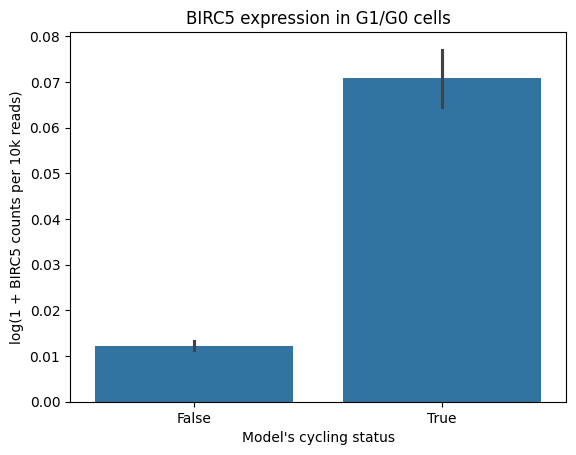

In [53]:
gene = "BIRC5"
# total_frac = 0
# for gene in SMALL_CYCLING_GENE_SET:
#     gene_fractions = get_gene_fractions(gene, adata[(g1_g0_indices)|(~cycling_cells.numpy())])
#     total_frac += gene_fractions
total_frac = get_gene_fractions(gene, adata[(g1_g0_indices) | (~cycling_cells.numpy())])

barplot_df = pd.DataFrame(
    {
        "gene_fractions": np.log(1 + total_frac * 1e4),
        "cycling_status": cycling_cells[(g1_g0_indices) | (~cycling_cells.numpy())],
    }
)
sns.barplot(
    data=barplot_df,
    x="cycling_status",
    y="gene_fractions",
    ax=plt.gca(),
)
plt.title(f"{gene} expression in G1/G0 cells")
plt.ylabel(f"log(1 + {gene} counts per 10k reads)")
plt.xlabel("Model's cycling status")
print(barplot_df.groupby("cycling_status").mean())

/tmp/ipykernel_372464/3920066266.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.histplot(x=thetas[~adata.obs["cycling"]])


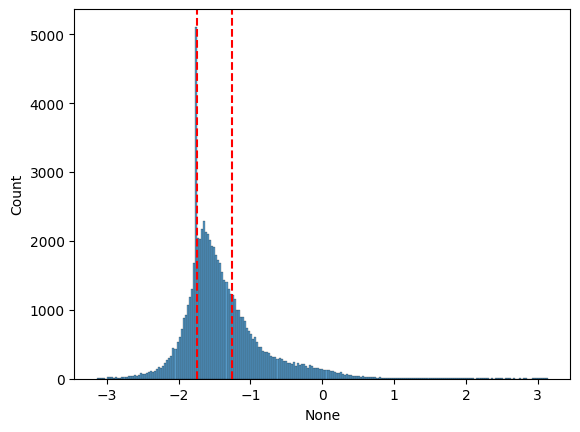

In [54]:
sns.histplot(x=thetas[~adata.obs["cycling"]])
# ad vertical lines at -1.25 and -1.75
plt.axvline(-1.25, color="red", linestyle="--")
plt.axvline(-1.75, color="red", linestyle="--")

<Axes: >

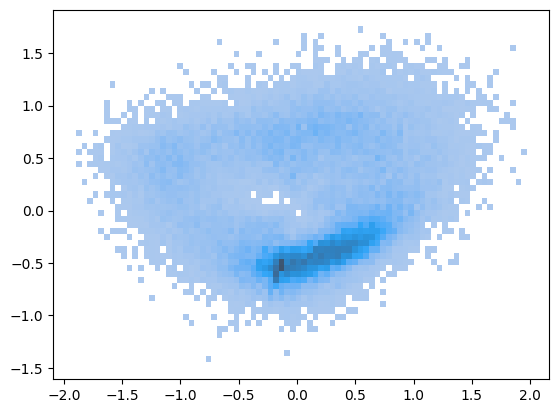

In [55]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[cycling_cells, 0], y=cells_projected[cycling_cells, 1])

<Axes: >

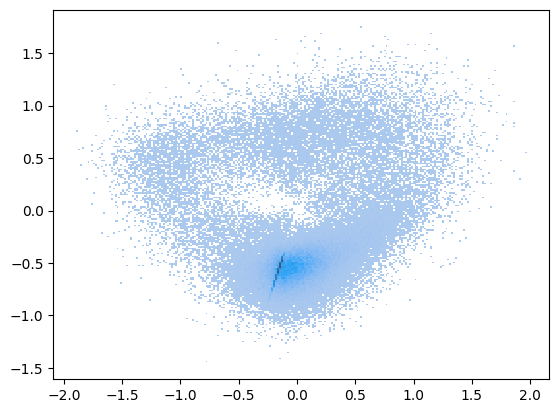

In [56]:
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

<Axes: xlabel='None', ylabel='Count'>

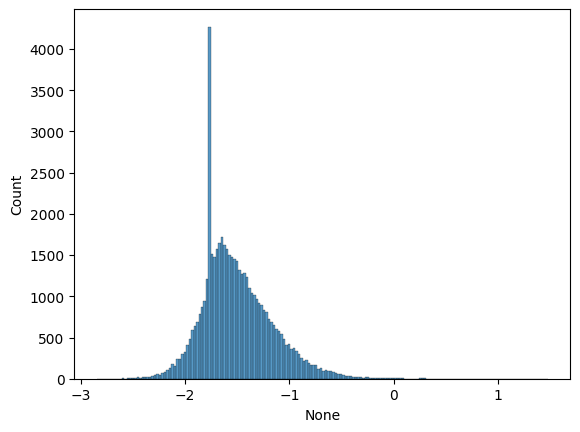

In [58]:
sns.histplot(x=thetas[~cycling_cells])

In [60]:
def add_theta(df, theta, theta_pca):
    df["inferred_theta"] = theta
    df["pca_theta"] = theta_pca
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas, adata.obs["pca_theta"].values)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(df_rhythmic, thetas, adata.obs["pca_theta"].values)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas, adata.obs["pca_theta"].values)

<Axes: xlabel='inferred_theta', ylabel='pca_theta'>

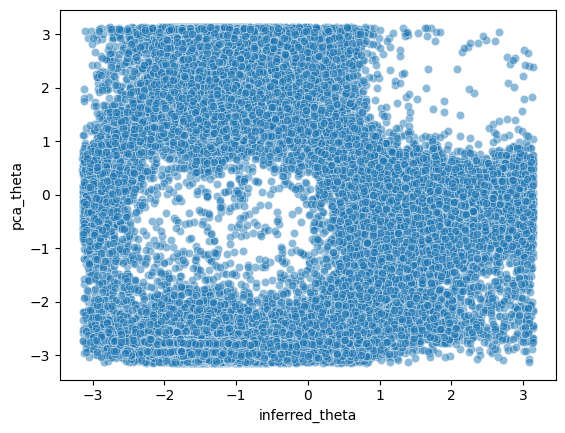

In [61]:
sns.scatterplot(
    data=df_mean, x=df_mean["inferred_theta"], y=df_mean["pca_theta"], alpha=0.5
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


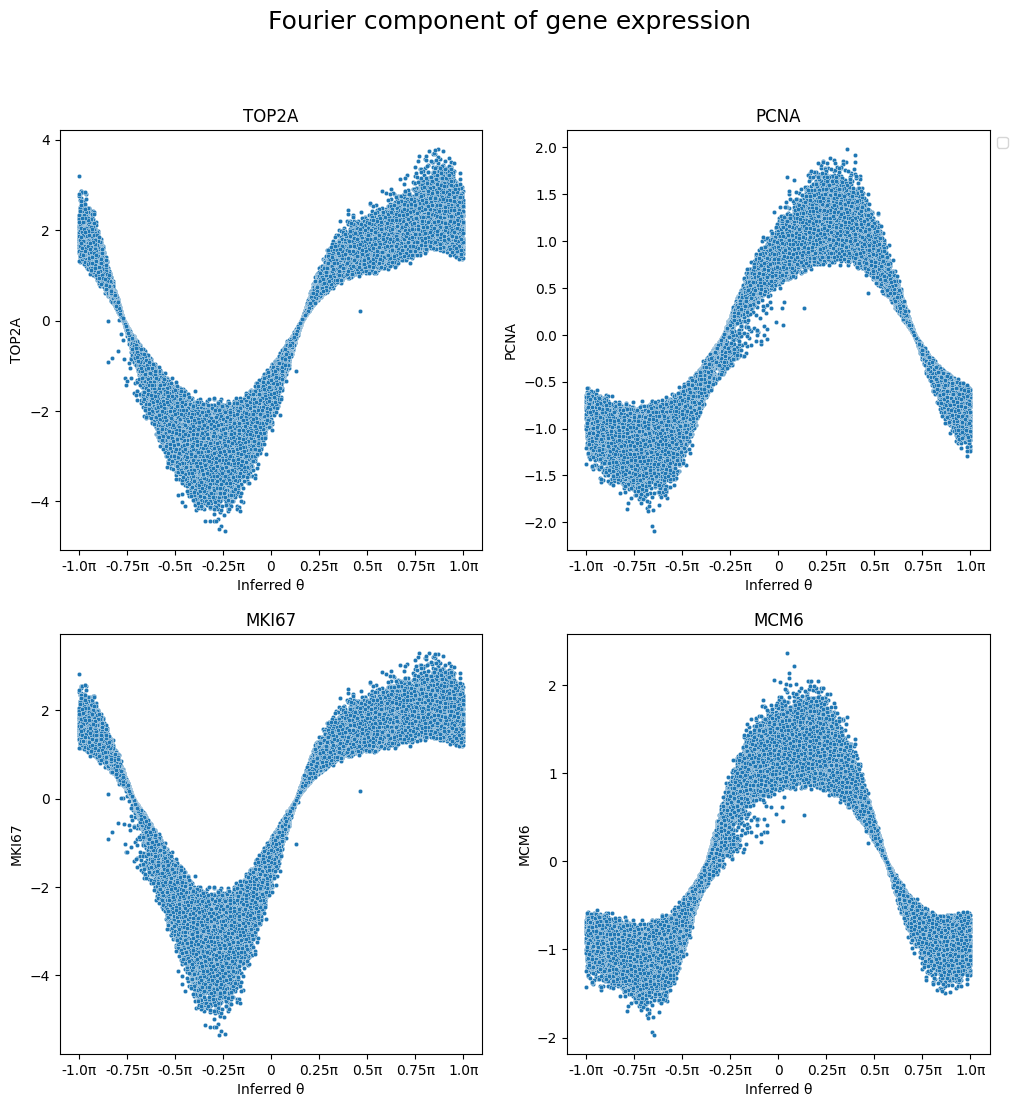

In [62]:
plotting.plot_model_decoded_space(
    df_rhythmic.loc[cycling_cells.detach().numpy()],
    gene_to_upper=True,
    title="Fourier component of gene expression",
)

In [63]:
library_size = adata.layers["total"].sum(axis=1).A1

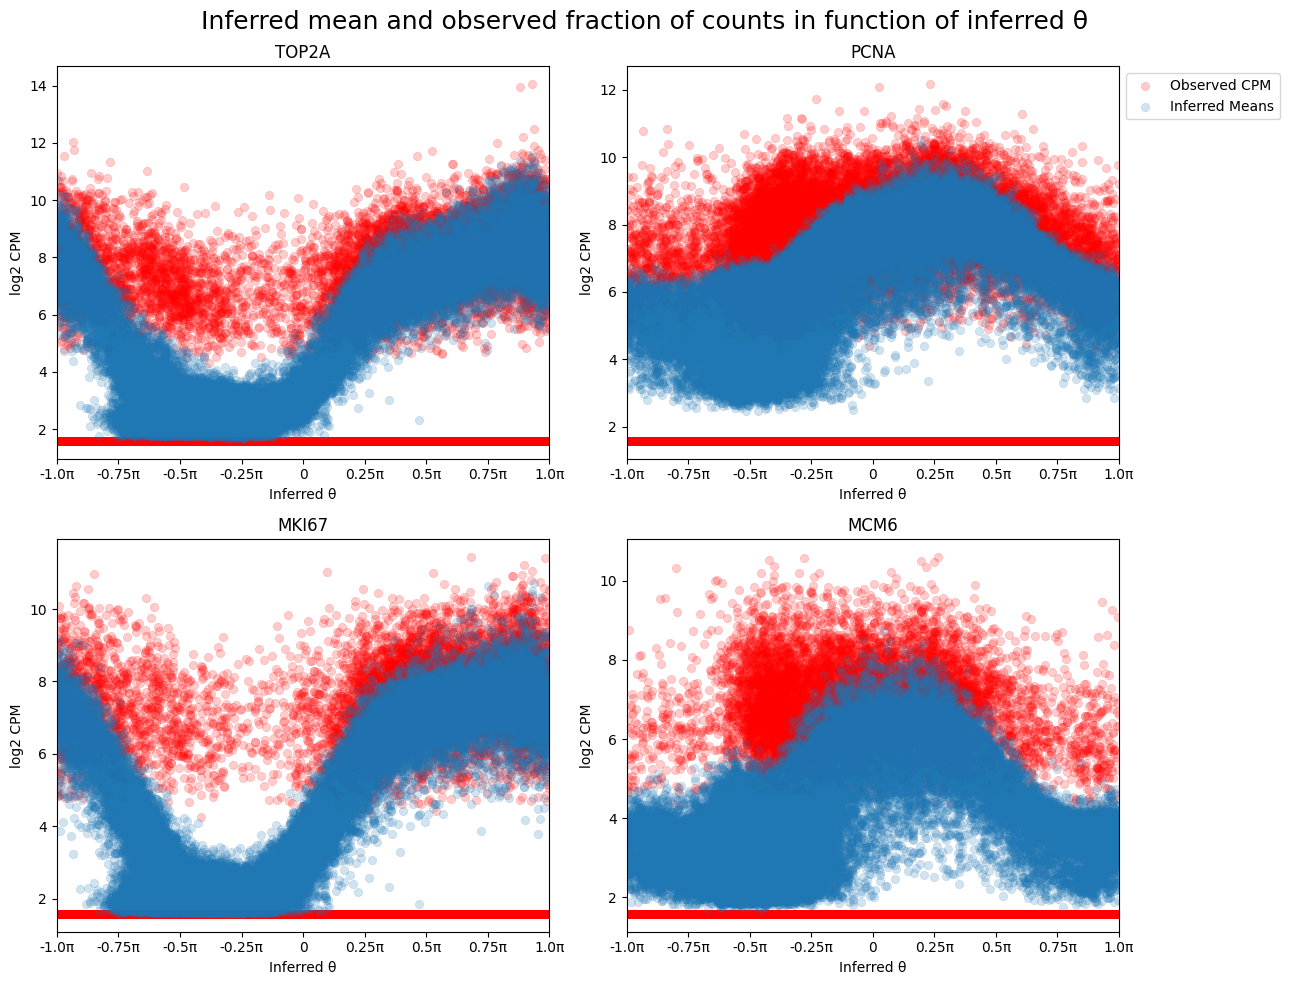

In [64]:
# plot the two with different y scales
genes = ["Top2a", "Pcna", "Mki67", "Mcm6"]
plotting.plot_gene_profile(
    df_mean, adata, genes, layer_to_use="total", library_size=library_size
)

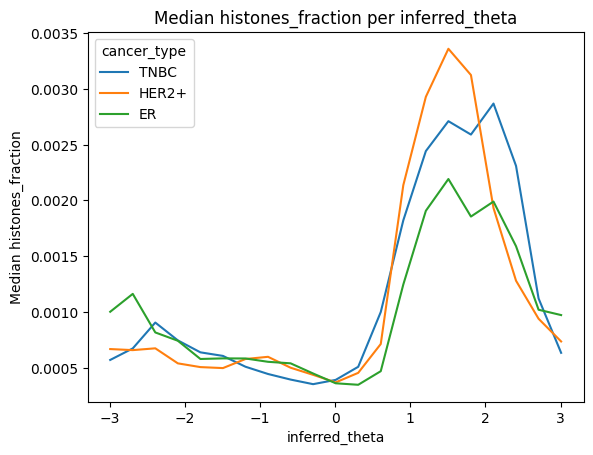

In [65]:
utils.add_histones_fraction(adata=adata, layer="total")

adata.obs["library_size"] = library_size
adata.obs["inferred_theta"] = utils.normalize_angles(
    df_mean["inferred_theta"].to_numpy()
)
plotting.plot_smoothed_size_evolution(
    adata[cycling_cells.detach().numpy()],
    "inferred_theta",
    counts_sum_field="histones_fraction",
    hue="cancer_type",
)

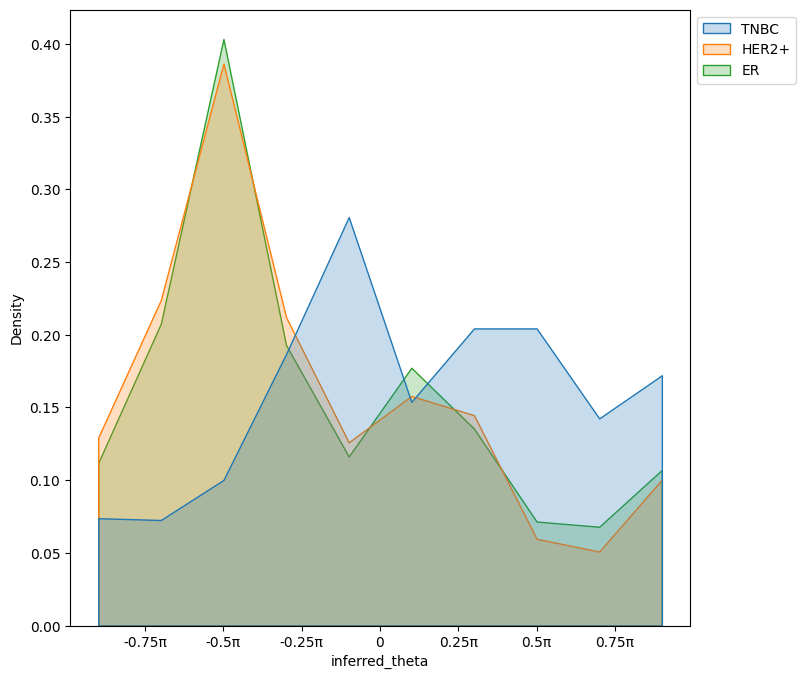

In [66]:
fig, ax = plotting.modify_axis_labels()
sns.histplot(
    x=df_z.loc[cycling_cells.numpy(), "inferred_theta"],
    hue=adata[cycling_cells.numpy()].obs["cancer_type"].values,
    stat="density",
    common_norm=False,
    ax=ax,
    element="poly",
    bins=10,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='cancer_type', ylabel='cycling_status'>

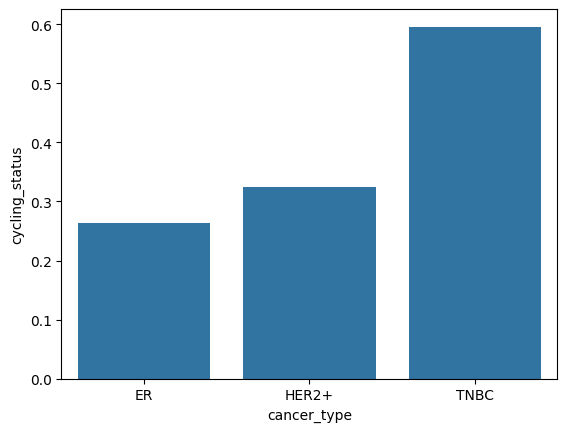

In [67]:
df_barplot = pd.DataFrame(
    {
        "cancer_type": adata.obs["cancer_type"].values,
        "cycling_status": cycling_cells.numpy(),
    }
)
df_barplot = df_barplot.groupby("cancer_type")["cycling_status"].mean().reset_index()
sns.barplot(data=df_barplot, x="cancer_type", y="cycling_status")

In [68]:
torch.arctan2(
    model.rhythmic_decoder.fourier_coefficients.weight[model.rhythmic_gene_indices, 1],
    model.rhythmic_decoder.fourier_coefficients.weight[model.rhythmic_gene_indices, 0],
)

tensor([0.6329, 2.3617, 0.7384, 2.0344, 2.5364, 1.2662, 2.6269, 1.0162, 1.0591,
        0.7973, 0.3408, 2.3976, 2.4052, 2.0135, 0.0810, 2.1737, 2.0995, 2.0121,
        0.4450, 0.7093, 2.1029, 2.3863, 1.5280, 0.3545, 1.6000, 1.9848, 2.0004,
        1.0640, 0.4940, 1.4489, 0.3401, 0.8820, 2.0666, 0.7359, 2.3379, 2.0815,
        2.3003, 2.4378, 0.2454, 0.3014, 0.5169, 2.3231, 0.9240, 1.2219, 2.5570,
        0.4439, 2.2093, 2.1768, 0.9902, 2.1913, 1.9943, 2.4551, 2.3421, 1.9916,
        2.1146, 0.4618, 2.1729, 0.7114, 2.2008, 1.2543, 1.3028, 1.3065, 1.5199,
        2.2650, 0.8279, 1.5609, 0.6181, 1.3443, 2.0397, 2.1093, 2.2282, 2.1924,
        0.6427, 1.6677, 2.1120, 2.2932, 2.0114, 0.5638, 2.5359, 1.0504, 2.3000,
        2.3335, 2.0038, 0.8972, 0.6472, 1.8049, 2.4407, 2.1754, 2.3461, 2.5111,
        1.8032, 2.2123, 2.0344, 1.5868, 0.5427, 2.3687, 2.4536, 1.0556],
       device='cuda:0', grad_fn=<Atan2Backward0>)

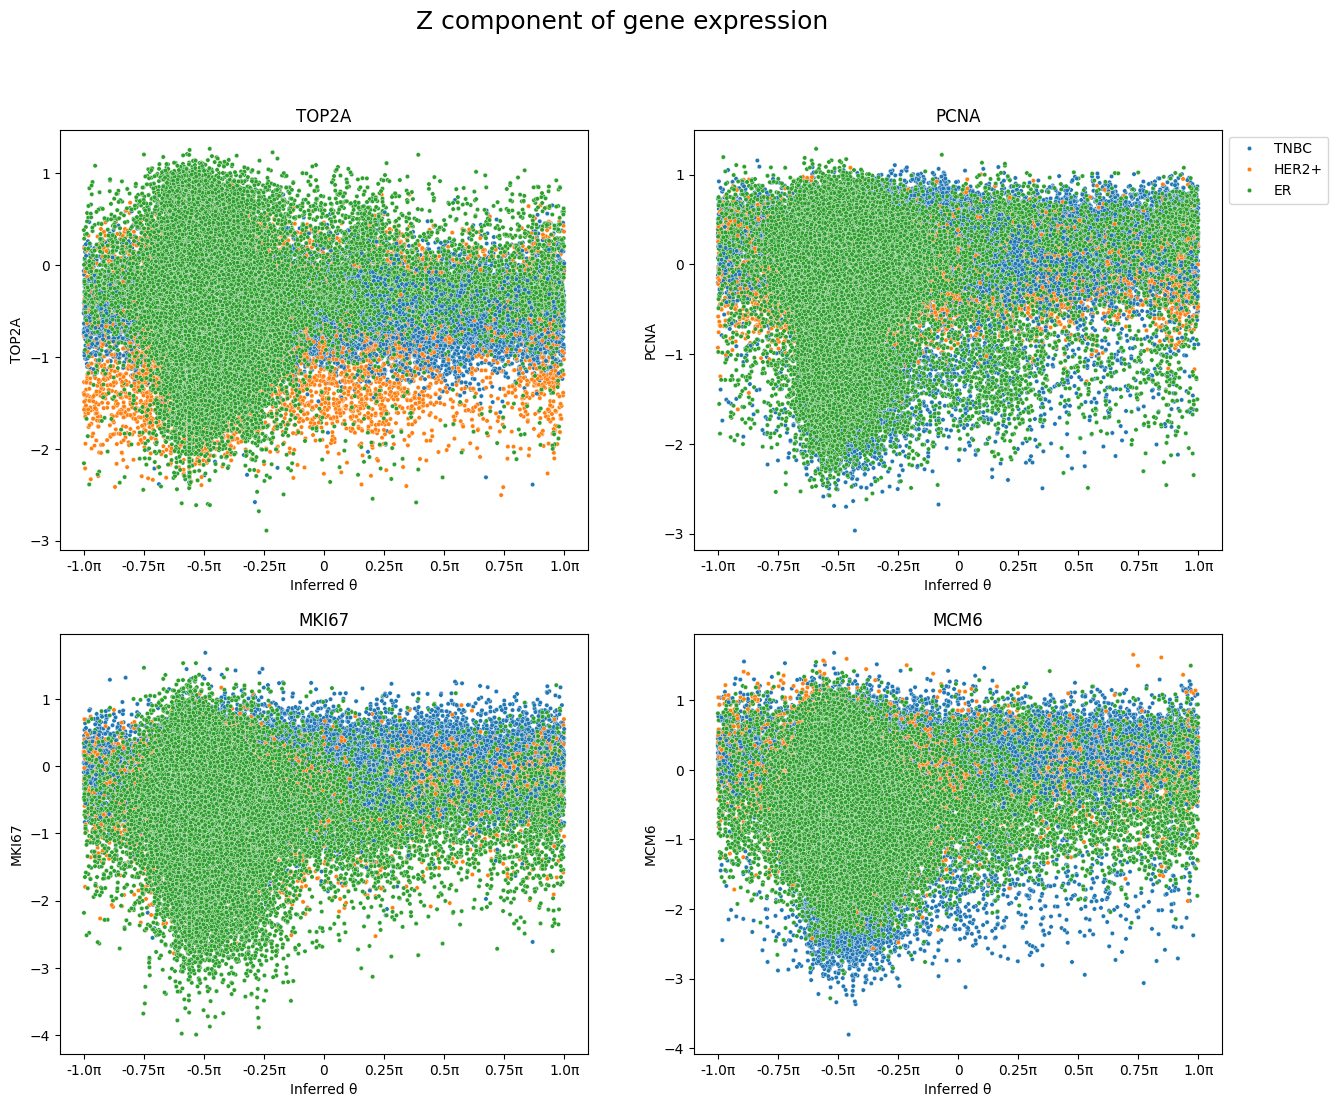

In [69]:
plotting.plot_model_decoded_space(
    df_z,
    gene_to_upper=True,
    hue=adata.obs["cancer_type"].values,
    title="Z component of gene expression",
)

In [70]:
df_z_diff = df_z.groupby(by=adata.obs["cancer_type"].values).mean()
df_z_diff = df_z_diff.loc[:, df_z_diff.columns.isin(SMALL_CYCLING_GENE_SET)]
df_z_diff = df_z_diff - df_z_diff.mean()
df_z_diff.abs().max().sort_values(ascending=False).head(10)

CDCA7     1.277037
CDC20     0.841870
ANP32E    0.839455
PIMREG    0.820054
NDC80     0.802113
CDC45     0.791937
TYMS      0.714220
CDCA2     0.691310
HMGB2     0.628248
CDCA3     0.611821
dtype: float32

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


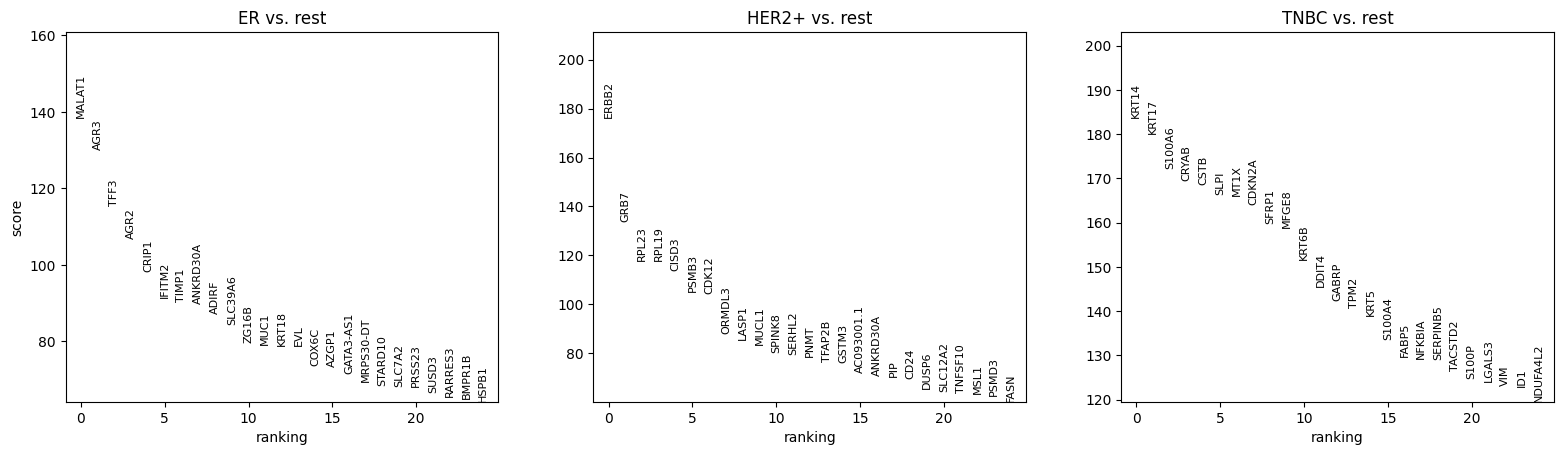

In [71]:
adata_deg = adata.copy()
adata_deg.X = adata_deg.layers["total"]
adata_deg = adata_deg[:, g]
sc.pp.normalize_total(adata_deg, target_sum=1e4)
sc.pp.log1p(adata_deg)
sc.tl.rank_genes_groups(
    adata_deg, "cancer_type", method="wilcoxon", key_added="wilcoxon"
)
sc.pl.rank_genes_groups(adata_deg, n_genes=25, sharey=False, key="wilcoxon")

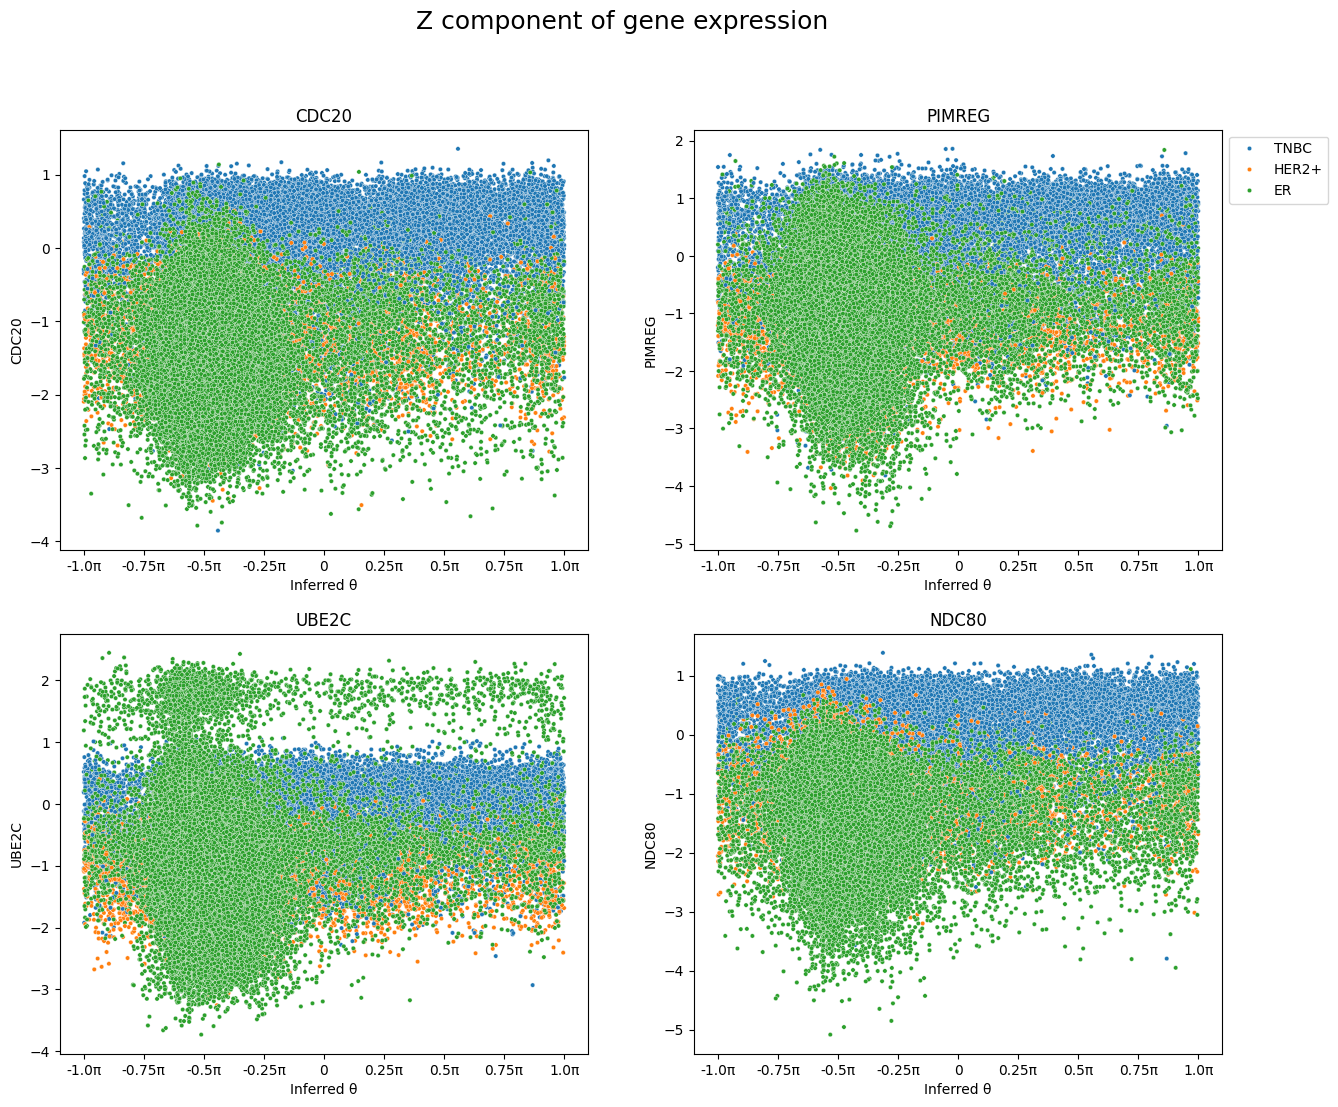

In [72]:
plotting.plot_model_decoded_space(
    df_z,
    gene_to_upper=True,
    hue=adata.obs["cancer_type"].values,
    title="Z component of gene expression",
    genes=["CDC20", "PIMREG", "UBE2C", "NDC80"],
)

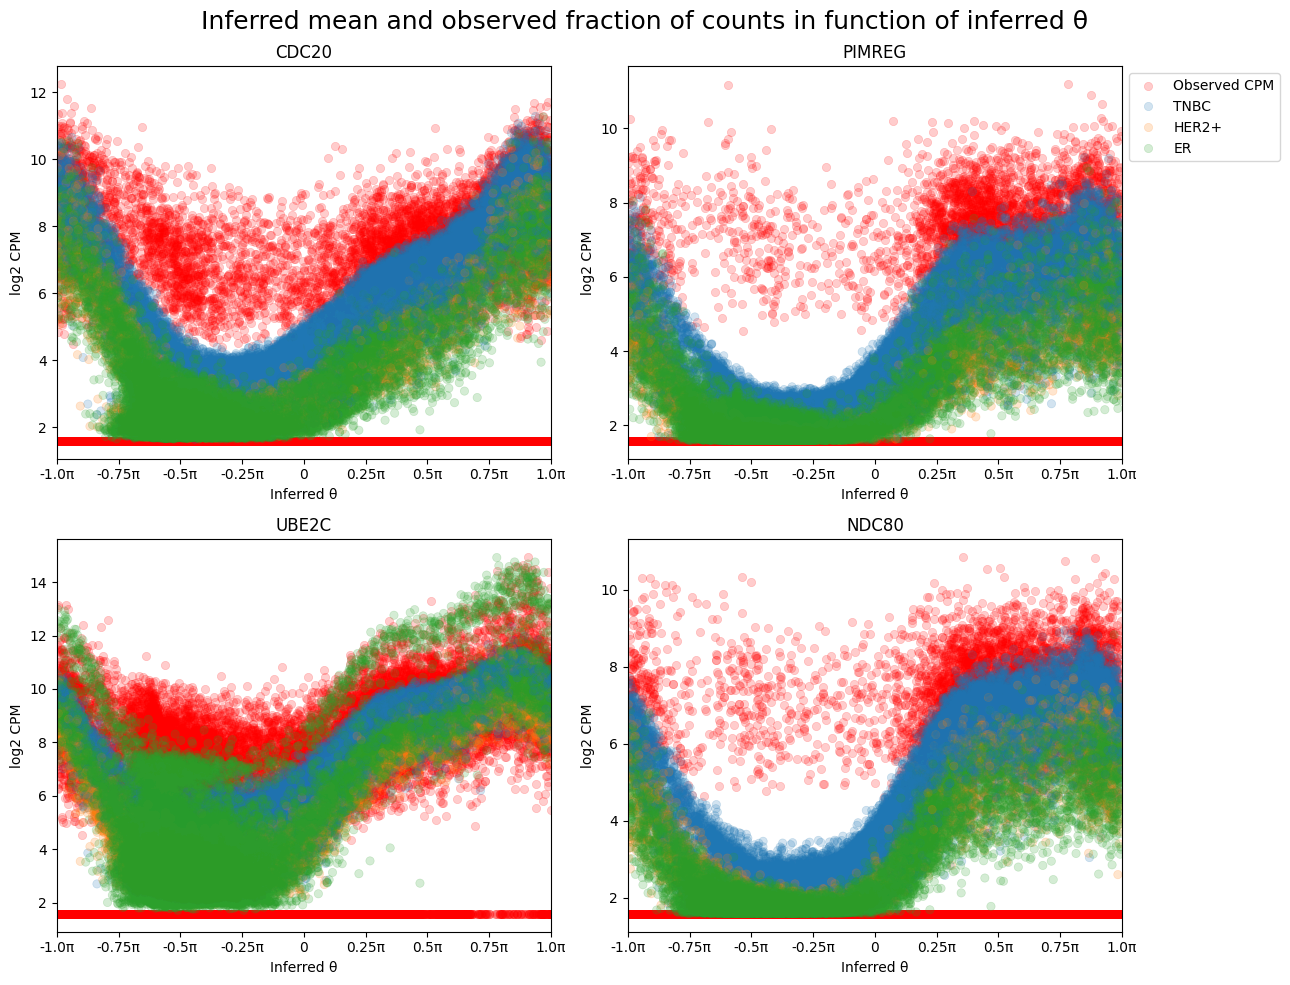

In [73]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    genes=["CDC20", "PIMREG", "UBE2C", "NDC80"],
    layer_to_use="total",
    library_size=library_size,
    hue=adata.obs["cancer_type"].values,
)

In [74]:
df_counts_norm = pd.DataFrame(
    np.log1p(
        adata[:, g].layers["total"].todense() / library_size.reshape(-1, 1) * 10e4
    ),
    index=adata.raw,
    columns=g,
)

In [75]:
df_counts_norm["inferred_theta"] = df_mean["inferred_theta"].values
df_counts_norm["cancer_type"] = adata.obs["cancer_type"].values

In [76]:
adata.obs["library_size"] = library_size
adata.obs["inferred_theta"] = df_mean["inferred_theta"].to_numpy()

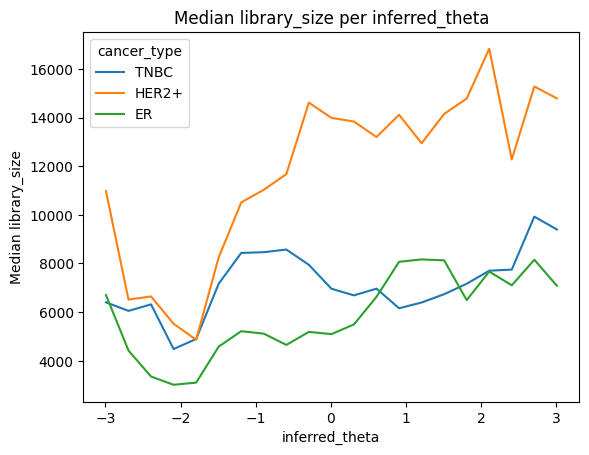

In [77]:
plotting.plot_smoothed_size_evolution(adata, "inferred_theta", hue="cancer_type")

<Axes: xlabel='inferred_theta'>

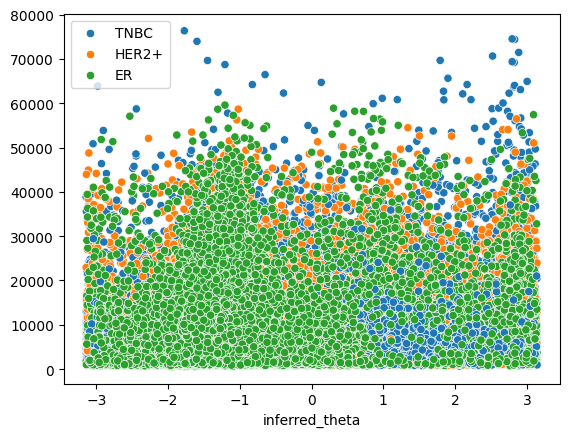

In [78]:
sns.scatterplot(
    x=df_mean["inferred_theta"], y=library_size, hue=adata.obs["cancer_type"].values
)

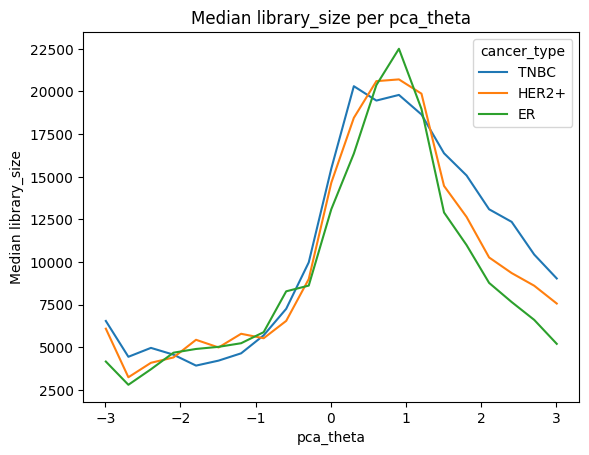

In [79]:
plotting.plot_smoothed_size_evolution(adata, "pca_theta", hue="cancer_type")

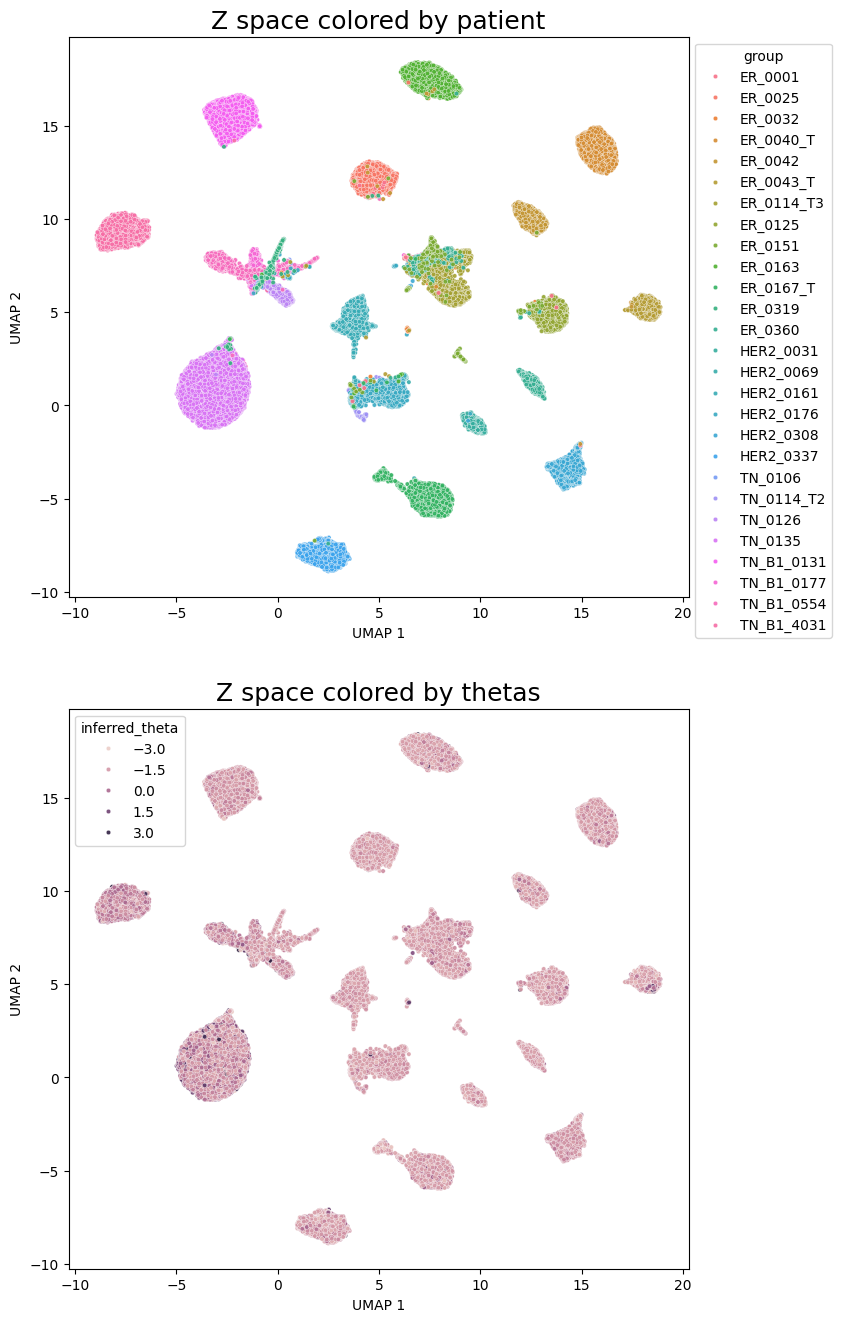

In [80]:
plotting.plot_z_space(
    space_outputs["z"],
    adata.obs["group"].astype("category"),
    adata.obs["inferred_theta"],
    cell_identity_label="patient",
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


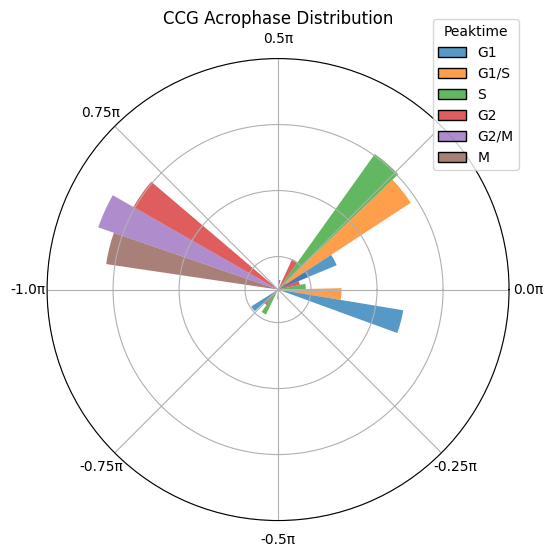

In [81]:
plotting.plot_cell_cycle(df_rhythmic)

<Axes: >

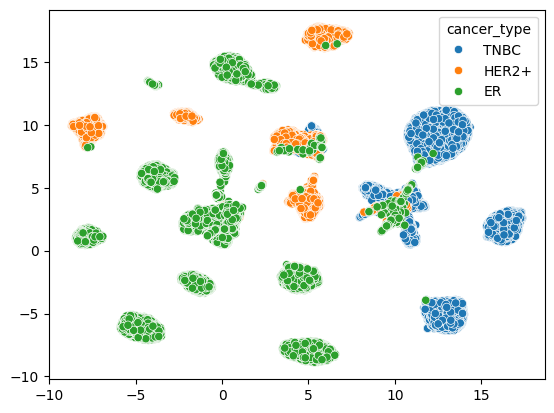

In [86]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(space_outputs["z"].detach().numpy())
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=adata.obs["cancer_type"])

In [87]:
logits = space_outputs["cycling_logits"].detach().numpy()
logits

array([ 7.0091424,  8.895044 , 20.       , ..., -2.8017106, -2.5887604,
       -2.263787 ], dtype=float32)

In [88]:
cells_in_g1_g0 = ((thetas > -1.75) & (thetas < -1.25)).numpy()

In [89]:
space_outputs["b_z"] > 0.5

tensor([ True,  True,  True,  ..., False, False, False])

<Axes: ylabel='Count'>

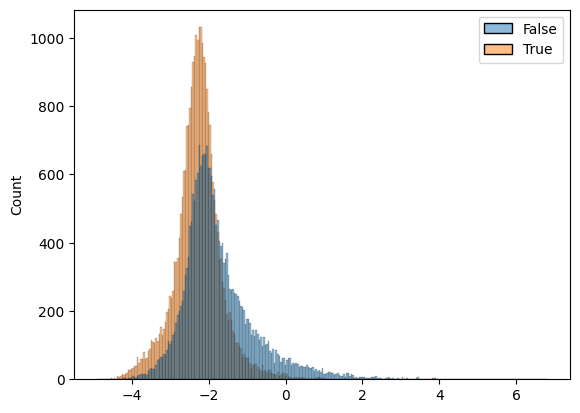

In [90]:
sns.histplot(x=logits[~cycling_cells], hue=(cells_in_g1_g0[~cycling_cells]))

In [91]:
to_save = {
    "z_space_embedding": embedding,
    "inferred_theta": df_mean["inferred_theta"].to_numpy(),
    "cycling_cells": cycling_cells.detach().numpy(),
    "latent_z": space_outputs["z"].detach().numpy(),
    "adata": adata,
    "df_f": df_rhythmic,
    "df_z": df_z,
    "df_mean": df_mean,
    "integrated_gradients": res,
    "logits": space_outputs["cycling_logits"].detach().numpy(),
}

In [92]:
# import pickle

# with open("data/breast_cancer_results.pkl", "wb") as f:
#     pickle.dump(to_save, f)